LOAD DEPENDENCIES AND DRIVE DATA

In [ ]:
!pip install -r Requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'Requirements.txt'


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


DATA PREPROCESSING

In [ ]:
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

#DEFINE DIRECTORY OF DATA AND CATEGORISE DATA
DIRECTORY = r"/content/drive/My Drive/Samples"
CATEGORIES = ["yes", "no"]

data = []
labels = []
ctr = 0

#LOAD DATA
for category in CATEGORIES:
  path = os.path.join(DIRECTORY, category)
  for img in os.listdir(path):
    ctr+=1
    img_path = os.path.join(path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(category)
    if ctr%100==0:
      print("Data loaded upto = " + str(ctr))
print("DATA loading complete")

Data loaded upto = 100
Data loaded upto = 200
Data loaded upto = 300
Data loaded upto = 400
Data loaded upto = 500
Data loaded upto = 600
Data loaded upto = 700
Data loaded upto = 800
Data loaded upto = 900
Data loaded upto = 1000
Data loaded upto = 1100
Data loaded upto = 1200
Data loaded upto = 1300
Data loaded upto = 1400
Data loaded upto = 1500
Data loaded upto = 1600
Data loaded upto = 1700
Data loaded upto = 1800
Data loaded upto = 1900
Data loaded upto = 2000
Data loaded upto = 2100
Data loaded upto = 2200
Data loaded upto = 2300
Data loaded upto = 2400
Data loaded upto = 2500
Data loaded upto = 2600
Data loaded upto = 2700
Data loaded upto = 2800
Data loaded upto = 2900
Data loaded upto = 3000
Data loaded upto = 3100
Data loaded upto = 3200
Data loaded upto = 3300
DATA loading complete


LABEL BINARIZER

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
print(labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


TEST SET DEFINE

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.10, stratify=labels, random_state=42)
#USE OF TRAINING DATA SET TO CREATE A RANDOM TEST SET

IMAGE AUGMENTATION

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

NEURAL NETWORK CONSTRUCTION

In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(102, activation="relu")(headModel) #LAYER 1
headModel = Dropout(0.5)(headModel)

headModel = Dense(46, activation="relu")(headModel) #LAYER 2
headModel = Dropout(0.4)(headModel)

headModel = Dense(21, activation="relu")(headModel) #LAYER 3
headModel = Dropout(0.33)(headModel)

headModel = Dense(10, activation="relu")(headModel) #LAYER 4
headModel = Dropout(0.25)(headModel)

headModel = Dense(4, activation="relu")(headModel) #LAYER 5
headModel = Dropout(0.1)(headModel)

headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
	layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


TRAINING MODEL

In [ ]:
print("[INFO] compiling model...")
# DEFINE TRAINING PARAMETERS
INIT_LR = 1e-3
EPOCHS = 500
BS = 50
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/500
60/60 [==============================] - 30s 507ms/step - loss: 0.6070 - accuracy: 0.6550 - val_loss: 0.3622 - val_accuracy: 0.9288
Epoch 2/500
60/60 [==============================] - 30s 495ms/step - loss: 0.4382 - accuracy: 0.7977 - val_loss: 0.2373 - val_accuracy: 0.9318
Epoch 3/500
60/60 [==============================] - 29s 488ms/step - loss: 0.3710 - accuracy: 0.8473 - val_loss: 0.1638 - val_accuracy: 0.9555
Epoch 4/500
60/60 [==============================] - 29s 489ms/step - loss: 0.3382 - accuracy: 0.8765 - val_loss: 0.1520 - val_accuracy: 0.9555
Epoch 5/500
60/60 [==============================] - 29s 487ms/step - loss: 0.3047 - accuracy: 0.9010 - val_loss: 0.1387 - val_accuracy: 0.9555
Epoch 6/500
60/60 [==============================] - 29s 485ms/step - loss: 0.2841 - accuracy: 0.9081 - val_loss: 0.1313 - val_accuracy: 0.9674
Epoch 7/500
60/60 [==============================] - 29s 490ms/step - loss: 0.2596 - a

SAVE MODEL

In [ ]:
print("[INFO] saving detector model...")
model.save("detector.model", save_format="h5")


[INFO] saving detector model...


PLOT ACCURACY OF TRAINING

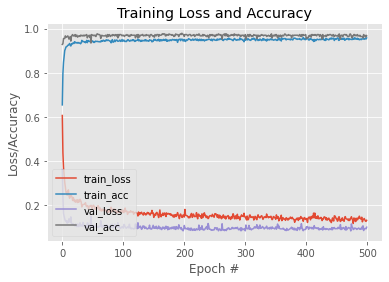

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

CONFUSION MATRIX OF MODEL

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import numpy as np
model_path = r"/content/drive/MyDrive/detector.model"
diaNet = load_model(model_path)

data1 = np.array(data, dtype="float32")
preds = diaNet.predict(data1,batch_size=20)
pred_label = ["yes" if yes>no else "no" for [no,yes] in preds]
'''
True positive  - actual = yes, predicted = yes
True negative  - actual =  no, predicted =  no
False positive - actual = yes, predicted =  no
False negative - actual =  no, predicted = yes
'''
conMat = confusion_matrix(labels, pred_label).ravel()
[tn, fp, fn, tp] = conMat
print("True Negative = " + str(tn))
print("False Positive = " + str(fp))
print("False Negative = " + str(fn))
print("True Positive = " + str(tp))
acc = (tn+tp)/(tn+fp+fn+tp)*100
print("Accuracy of the model = " + str(round(acc,2)) + "%")

True Negative = 1745
False Positive = 60
False Negative = 63
True Positive = 1499
Accuracy of the model = 96.35%


ENTER TEST IMAGE

In [1]:
from tensorflow.keras.models import load_model
from google.colab import files
#LOAD TEST IMAGE
files.upload()

Saving f901d460517c.png to f901d460517c.png


{'f901d460517c.png': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd\xb6\x00\x00 \x00IDATx\x01t\xc1i\xb0m\xe9Y\x18\xe6\xf7\xfd\xa65\xaf=\x9e}\xe6;v\xdfn5\xea\x96\x84\x84\xc0\x02,@!@p\x08\xc46\xe0"`\x12\xfd\xc0)W\x1cC*\x85\x1d:p\x91\xa0\x0cN\xc5\xe5\x10W\xc5\x15\xc7\x05\xc6n\x04\x19J\x80\x03R\x1203\x024"\xf5p\xd5}\xe73\xee\xb3\xc7\xb5\xf6\x9a\xbe9\xb7\x8f\x90J\xae8\xcf\x83/\xbe\xf8"\x03\x06\x0c\x8c\x07j=\x01\xc7\x99h\xbd\xd5\xd6\x0c\x83D\x82\xb1\xd6zc=A\xef=x\xa0\x8cz\xef\x03\x80\x96\xba\xc4\xb1\x0e,\x00\x01\x00cL\x10\x04\xce9\xe1HM$x\x88I.Q\xa2\xb5\x06\xc0Y\xcb\x85\xe0\x0e=\xf1\xd6Zim\x12\x04\xc6\x18\x8bH)5\xc68g\t\xe1\xdcRC4E\xf0\x94\n\xe7\xee\xcd\x8b_\xfe\x83\xb3?z\xe9\xed\x9f\xfb\xdd\xc5\xab\x9f\x8e\x87\xcf\xc5\xd4\x82S\n\xb5\x11\xc3l:\x9d_\xdb\x99\x9c\x9c,\xfa}\xd1j\xe6\x1amVn\xf7V0\xef\xc2<\xab\xcf\xa6>p\xe1\xe1\xae\xebX\xe1\xa61\xf6\x02\xcbx"\xf1u3\xbd\xa9v\xf4\x16\xac\x9a:\xa8\x9a\x99\xf3\xbbN\xc8]\xee\x8a\x9aP\x0e\xcce\xe1\xf8\

FINAL RESULT DIABETES DETECTION

1/1 [==============================] - 1s 781ms/step


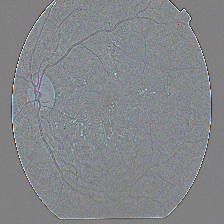

Diabetes Detected with 100.0% probability


In [7]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
from skimage import io
import numpy as np

img = load_img('f901d460517c.png')
img = img_to_array(img)
img = preprocess_input(img)
I = [img]
diaNet = load_model("/content/drive/MyDrive/Diabetic Retinopathy/detector.model")
I = np.array(I, dtype="float32")
[[yes,no]] = diaNet.predict(I, batch_size = 50)
cv2_imshow(io.imread('f901d460517c.png'))
if yes<no:
    print("Diabetes Detected with " + str(round(no*100,2)) + "% probability")
else :
    print("No Diabetes Detected "+ str(round(yes*100,2)) + "% probability")